# Introduction to this python notebook

In [ ]:
"""
What? Successive Halving Iterations

Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-iterations-py
"""

# Import python modules

In [4]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import randint
import numpy as np
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from pylab import rcParams

In [ ]:
"""
We first define the parameter space and train a HalvingRandomSearchCV instance.
"""

In [2]:
rng = np.random.RandomState(0)

X, y = datasets.make_classification(n_samples=700, random_state=rng)

clf = RandomForestClassifier(n_estimators=20, random_state=rng)

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rsh = HalvingRandomSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    factor=2,
    random_state=rng)
rsh.fit(X, y)

HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=RandomState(MT19937) at 0x1211F8D40),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10559a0d0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12128c8b0>},
                      random_state=RandomState(MT19937) at 0x1211F8D40,
                      refit=<function _refit_callable at 0x12079d4c0>)

In [ ]:
"""
We can now use the cv_results_ attribute of the search estimator to inspect and plot the evolution of the search.
"""

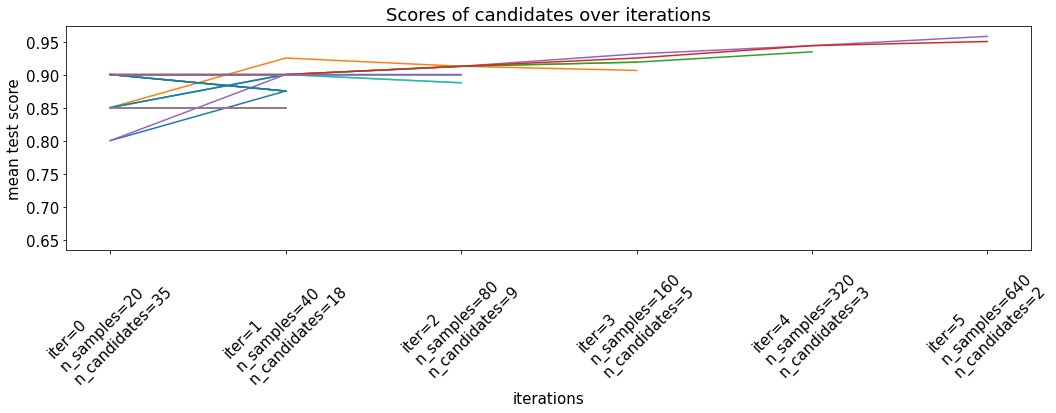

In [11]:
results = pd.DataFrame(rsh.cv_results_)
results['params_str'] = results.params.apply(str)
results.drop_duplicates(subset=('params_str', 'iter'), inplace=True)

rcParams['font.size'] = 15
rcParams['figure.figsize'] = 15, 6

mean_scores = results.pivot(index='iter', columns='params_str',
                            values='mean_test_score')
ax = mean_scores.plot(legend=False, alpha=1)

labels = [
    f'iter={i}\nn_samples={rsh.n_resources_[i]}\n'
    f'n_candidates={rsh.n_candidates_[i]}'
    for i in range(rsh.n_iterations_)
]



ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment='left')
ax.set_title('Scores of candidates over iterations')
ax.set_ylabel('mean test score', fontsize=15)
ax.set_xlabel('iterations', fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
"""
At the first iteration, a small amount of resources is used. The resource here is the number of samples that
the estimators are trained on. All candidates are evaluated.

At the second iteration, only the best half of the candidates is evaluated. The number of allocated resources 
is doubled: candidates are evaluated on twice as many samples.

This process is repeated until the last iteration, where only 2 candidates are left. The best candidate is the
candidate that has the best score at the last iteration.
"""